In [240]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import random
import time
from numpy import exp
from tqdm import tqdm_notebook as tqdm

#### Reads file into numpy array

In [241]:
def get_data(path):
    '''This function returns csv file as a numpy matrix.'''
    return np.loadtxt(open(path,'r'),delimiter=',')

#### Data Splitting 

In [242]:
def split_data(X,t,test_ratio=1/3):
    '''This function splits the dataset into training and test data'''
    n=np.shape(X)[0]
    test_index=np.random.choice(np.arange(0,n),replace=False,size=int(n*test_ratio))
    train_index=np.array(list(set(np.arange(0,n))-set(test_index)))
    
    X_test=X[test_index,:]
    t_test=t[test_index,:]
    
    X_train=X[train_index,:]
    t_train=t[train_index,:]
    
    return X_train,t_train,X_test,t_test  

def subset_data(X,t,ratio):
    '''This function returns a random subset of the data'''
    n=np.shape(X)[0]
    index=np.random.choice(np.arange(0,n),replace=False,size=int(n*ratio))
    return X[index,:],t[index,:]

#### Data Pre-processing

In [243]:
def process_train(X_train):
    '''This function scales the training data.'''
    means=np.mean(X_train[:,1:],axis=0).reshape(1,np.shape(X_train)[1]-1)
    std_dev=np.std(X_train[:,1:],axis=0).reshape(1,np.shape(X_train)[1]-1)
    
    X_train[:,1:]=(X_train[:,1:]-means)/std_dev
    return X_train,means,std_dev
    
def process_test(X_test,means,std_dev):
    '''This function scales the test data based on the means and std_dev of train data'''
    X_test[:,1:]=(X_test[:,1:]-means)/std_dev
    return X_test

#### Class for Ordinal regression. (Setting up hyperparameters.)

In [244]:
class Ordinal:
    def __init__(self,s,phi):
        self.s=s
        self.phi=phi
    
    def get_hyperparameters(self):
        return self.s,self.phi

#### Evidence maximisation for optimal hyperparameters

In [245]:
def calculate_alpha_new(Gamma,W_MAP) :
    return Gamma/(np.matmul(W_MAP.T,W_MAP)[0,0])

def calculate_Gamma(alpha_old,X,R):
    V,U=np.linalg.eigh(X.T @ R @ X)
    Gamma=0
    for val in V:
        Gamma+=val/(val+alpha_old)
    return Gamma

#### Generalised Linear Model functions

In [296]:
def sigmoid(a):
    '''This function returns the sigmoid of the value'''
    return 1/(1+exp(-a))



def exponential(a):
    '''This function returns the exponential of the value.'''
    return exp(a)

    
    
def calculate_y(W,X,t,model,ob=None):
    '''This function calculates the y for different models'''
    y=np.zeros(shape=(np.shape(X)[0],2))
    a=X @ W                           
    
    if(model=='Logistic'):
        for i in range(0,y.shape[0]):
            y[i,0]=sigmoid(a[i,0])
            
    elif(model=='Poisson'):
        for i in range(0,y.shape[0]):
            y[i,0]=exponential(a[i,0])
            
    elif(model=='Ordinal'):
        phi=ob.phi
        for i in range(0,y.shape[0]):
            t_=int(t[i,0])
            y[i,0]=sigmoid(s*(phi[t_]-a[i,0]))
            y[i,1]=sigmoid(s*(phi[t_-1]-a[i,0]))
    return y


def calculate_d(t,y,model):
    '''This function calculates the d for different models'''
    if(model=='Logistic' or model=='Poisson'):
        d=t[:,0]-y[:,0]
        d=d.reshape(-1,1)
        return d
    elif(model=='Ordinal'):
        d=y[:,0]+y[:,1]-1
        d=d.reshape(-1,1)
        return d


    
def calculate_r(y,model,ob=None):
    '''This fucntion calculates the r for different models.'''
    if(model=='Logistic'):
        r=np.multiply(y[:,0],1-y[:,0])
        return np.diag(r)
    if(model=='Poisson'):
        r=y[:,0]
        return np.diag(r)
    if(model=='Ordinal'):
        s=ob.s
        phi=ob.phi
        a=np.multiply(y[:,0],1-y[:,0])
        b=np.multiply(y[:,1],1-y[:,1])
        r=s*s*(a+b) 
        return np.diag(r)
    


def calculate_gradient(X,d,W,alpha=10):
    '''This function calculates the gradient of the function.'''
    A=X.T @ d
    B=alpha*W
    return A-B


def calculate_hessian(X,R,alpha=10):
    '''This function calculate sthe hessian of the function'''
    A=alpha*np.identity(X.shape[1])
    B=(X.T @ R ) @ X
    return -1*(A+B)


def update_W(W_old,Hessian,gradient):
    '''This function updates the weight vector'''
    A=np.linalg.inv(Hessian) @ gradient
    return W_old-.2*A

def check_convergence(W_new,W_old,itr):
    '''This function checks if W has converged or not'''
    a=W_new-W_old
    num=(a.T @ a)[0,0]
    den=(W_old.T @ W_old)[0,0]
    if(den==0):
        return False
    elif((num/den)<(1e-3) or itr>=100):
        return True
    else:
        return False

def predict_label(X,W,model,ob=None):
    '''This function predicts the labels for different models'''
    a=X @ W
    label=np.zeros(shape=(X.shape[0],1))
    
    if(model=='Logistic'):
        for i in range(0,X.shape[0]):
            label[i,0]=sigmoid(a[i,0])
            if(label[i,0]>=.5):
                label[i,0]=1
            else:
                label[i,0]=0
    
    if(model=='Poisson'):
        for i in range(0,X.shape[0]):
            label[i,0]=exponential(a[i,0])
    
    if(model=='Ordinal'):
        phi=ob.phi
        s=ob.s
        for i in range(0,X.shape[0]):
            prob=np.zeros(len(phi))
            y=np.zeros(len(phi))
            for j in range(1,len(phi)):
                y[j]=sigmoid(s*(phi[j]-a[i,0]))
                prob[j]=y[j]-y[j-1]
            idx=0
            max_value=prob[0]
            for k in range(1,len(prob)):
                if(prob[k]>max_value):
                    max_value=prob[k]
                    idx=k
            label[i,0]=idx

    return label    
        
    
def calculate_error(predict,label,model):
    '''This fucntion calculates the error for different models.'''
    error=0;
    if(model=='Logistic'):
        for i in range(0,label.shape[0]):
            if(predict[i,0]!=label[i,0]):
                error+=1
    elif(model=='Poisson' or model=='Ordinal'):
        for i in range(0,label.shape[0]):
            error+=abs(predict[i,0]-label[i,0])
            
    return error/label.shape[0] 

#### Generalised Linear model (Without hyperparameter optimisation)

In [297]:
def train_GLM(X_train,t_train,model,ob):
    '''This function trains a Generalised Linear model depending on the model passed'''
    W_new=np.zeros(shape=(np.shape(X_train)[1],1))
    #W_new=10*np.random.rand(X_train.shape[1],1)
    W_old=np.ones(shape=(np.shape(X_train)[1],1))
    itr=0
    while(not check_convergence(W_new,W_old,itr)):
        Y=calculate_y(W_new,X_train,t_train,model,ob)
        d=calculate_d(t_train,Y,model)
        R=calculate_r(Y,model,ob)
        gradient=calculate_gradient(X_train,d,W_new)
        hessian=calculate_hessian(X_train,R)
        W_old=W_new
        W_new=update_W(W_old,hessian,gradient)
        itr+=1  
    return W_new,itr-1

def experiment(data_path,label_path,model,ob=None):
    '''This function returns average_error_rate, standard_deviation, average_run_time, average_iterations for the dataset passed.'''
    data=get_data(data_path)
    ones=np.ones(shape=(np.shape(data)[0],1))
    data=np.hstack((ones,data))

    label=get_data(label_path)
    label=label.reshape(len(label),1)

    X_train,t_train,\
    X_test,t_test=split_data(data,label)
    
    repeat=30
    ratio=np.arange(.1,1.1,.1)
    mean_size=np.zeros(len(ratio))
    std_size=np.zeros(len(ratio))
    itr_avg=np.zeros(len(ratio))
    run_time_avg=np.zeros(len(ratio))
    
    for i in range(0,len(ratio)):
        error_curr=[]
        itr_curr=[]
        run_time_curr=[]
        for j in range(0,repeat):
            X_train_sub,t_train_sub=subset_data(X_train,t_train,ratio[i])
            
            t0=time.clock()
            W_MAP,iterations=train_GLM(X_train_sub,t_train_sub,model,ob)
            #print(iterations)
            t1=time.clock()
            
            t_predict=predict_label(X_test,W_MAP,model,ob)
            error=calculate_error(t_predict,t_test,model)
            
            error_curr.append(error)
            itr_curr.append(iterations)
            run_time_curr.append(t1-t0)
            
        mean_size[i]=np.mean(error_curr)
        std_size[i]=np.std(error_curr)
        itr_avg[i]=np.mean(itr_curr)
        run_time_avg[i]=np.mean(run_time_curr)
    return mean_size,std_size,itr_avg,run_time_avg

#### Graph Plotting Functions

In [298]:
def plot_graph(X,Y,std_dev):
    '''This function plots the necessary graphs for the task'''
    plt.figure(1,figsize=(5,5))
    
    plt.scatter(X,Y,color='b')
    plt.plot(X,Y,color='b')
    plt.errorbar(X,Y,yerr=std_dev)
    plt.xlabel("Training data size")
    plt.ylabel("Average test error rate")
    plt.title('Variation of average test error rate as training size increases')
    plt.grid()
    plt.show()
    

### Running GLM for different datasets.

In [299]:
alpha=10
s=1
phi=[-np.inf,-2,-1,0,1,np.inf]

#### (1) Logistic regression models

##### (1.1) Dataset A

In [300]:
model='Logistic'
data_path='pp3data\\A.csv'
label_path='pp3data\\labels-A.csv'
mean_size,std_size,itr_avg,run_time_avg=experiment(data_path,label_path,model)

In [301]:
print("average error rate is : \n"+str(mean_size)+str("\n\n"))
print("average standard deviation is :\n"+str(std_size)+str("\n\n"))
print("average number of iterations are : \n"+str(itr_avg)+str("\n\n"))
print("average run_time is :\n"+str(run_time_avg)+str("\n\n"))

average error rate is : 
[0.43663664 0.39184184 0.37157157 0.3516016  0.33618619 0.32442442
 0.31591592 0.3        0.29034034 0.28528529]


average standard deviation is :
[0.02258716 0.01906171 0.01763325 0.01335736 0.01115802 0.01164307
 0.01320752 0.0113586  0.00791187 0.        ]


average number of iterations are : 
[ 9.16666667  9.86666667  9.96666667 10.         10.         10.
 10.         10.         10.         10.        ]


average run_time is :
[0.00484568 0.00866206 0.02032816 0.02905398 0.03658916 0.04569042
 0.06017411 0.07336796 0.07886426 0.09343728]




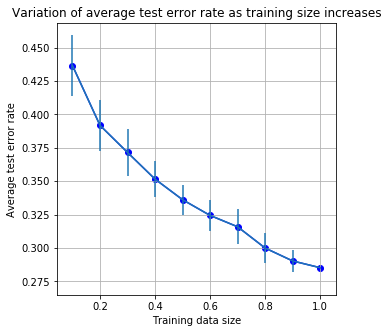

In [302]:
plot_graph(np.arange(.1,1.1,.1),mean_size,std_size)

• Average error rate is decreasing as the training size os increasing.<br>
• Standard deviation also reduces with increase in training size.<br>
• Average number of iterations required to converge to optimal solution is 10.<br>
• Average run time increases as the training sample size increases.<br>

###### (1.2) Dataset usps

In [286]:
model='Logistic'
data_path='pp3data\\usps.csv'
label_path='pp3data\\labels-usps.csv'
mean_size,std_size,itr_avg,run_time_avg=experiment(data_path,label_path,model)

In [287]:
print("average error rate is : \n"+str(mean_size)+str("\n\n"))
print("average standard deviation is :\n"+str(std_size)+str("\n\n"))
print("average number of iterations are : \n"+str(itr_avg)+str("\n\n"))
print("average run_time is :\n"+str(run_time_avg)+str("\n\n"))

average error rate is : 
[0.06452242 0.05328135 0.05159194 0.04957765 0.04515919 0.04405458
 0.04282001 0.04145549 0.04035088 0.03703704]


average standard deviation is :
[9.32621732e-03 6.31316845e-03 5.68838691e-03 4.71297929e-03
 3.49007122e-03 4.31793313e-03 2.99812138e-03 3.01707258e-03
 2.25930327e-03 1.38777878e-17]


average number of iterations are : 
[13.63333333 14.96666667 15.7        16.26666667 16.86666667 17.03333333
 17.23333333 17.53333333 17.93333333 18.        ]


average run_time is :
[0.03790473 0.05074053 0.06721882 0.08815482 0.12253495 0.14760623
 0.17736308 0.20871768 0.24674567 0.28175038]




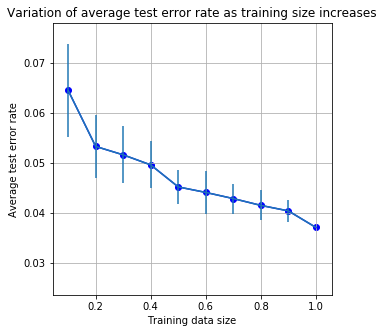

In [289]:
plot_graph(np.arange(.1,1.1,.1),mean_size,std_size)

• Average error rate is decreasing as the training size os increasing.<br>
• Standard deviation also reduces with increase in training size.<br>
• Average number of iterations required to converge to optimal solution is 16-18.<br>
• Average run time increases as the training sample size increases.<br>

#### (2) Poisson regression model

In [290]:
model='Poisson'
data_path='pp3data\\AP.csv'
label_path='pp3data\\labels-AP.csv'
mean_size,std_size,itr_avg,run_time_avg=experiment(data_path,label_path,model)

In [291]:
print("average error rate is : \n"+str(mean_size)+str("\n\n"))
print("average standard deviation is :\n"+str(std_size)+str("\n\n"))
print("average number of iterations are : \n"+str(itr_avg)+str("\n\n"))
print("average run_time is :\n"+str(run_time_avg)+str("\n\n"))

average error rate is : 
[1.17966716 1.07740338 1.04821248 1.02265914 1.00491583 0.99859877
 0.99266987 0.99223096 0.98782541 0.98366953]


average standard deviation is :
[3.35889234e-02 3.21601723e-02 2.47493326e-02 1.72863392e-02
 1.45467436e-02 8.24370676e-03 9.48629332e-03 5.27050268e-03
 5.75573415e-03 3.24316904e-16]


average number of iterations are : 
[7.53333333 7.03333333 7.         6.8        6.66666667 6.56666667
 6.36666667 6.06666667 6.03333333 6.        ]


average run_time is :
[0.00397231 0.00601953 0.0121179  0.01877816 0.02460881 0.02781883
 0.036614   0.04364411 0.04674609 0.05960685]




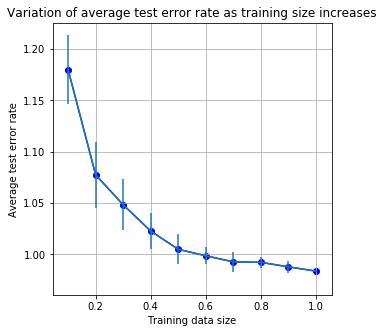

In [292]:
plot_graph(np.arange(.1,1.1,.1),mean_size,std_size)

• Average error rate is decreasing as the training size os increasing.<br>
• Standard deviation also reduces with increase in training size.<br>
• Average number of iterations required to converge to optimal solution is 7.<br>
• Average run time increases as the training sample size increases.<br>

#### (3) Ordinal regression model

In [303]:
model='Ordinal'
data_path='pp3data\\AO.csv'
label_path='pp3data\\labels-AO.csv'
ob=Ordinal(s,phi)
#print(ob.s)
#print(ob.phi)
mean_size,std_size,itr_avg,run_time_avg=experiment(data_path,label_path,model,ob)

In [304]:
print("average error rate is : \n"+str(mean_size)+str("\n\n"))
print("average standard deviation is :\n"+str(std_size)+str("\n\n"))
print("average number of iterations are : \n"+str(itr_avg)+str("\n\n"))
print("average run_time is :\n"+str(run_time_avg)+str("\n\n"))

average error rate is : 
[0.84874875 0.74964965 0.70900901 0.69089089 0.69069069 0.6994995
 0.7014014  0.70870871 0.70620621 0.71171171]


average standard deviation is :
[1.16027589e-01 5.49392722e-02 3.66755893e-02 2.11483820e-02
 1.46296904e-02 1.15249954e-02 1.23740082e-02 1.25265187e-02
 8.80937754e-03 1.11022302e-16]


average number of iterations are : 
[9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]


average run_time is :
[0.02132092 0.04380256 0.07339286 0.10109823 0.13630429 0.16800147
 0.20092661 0.24173028 0.26943607 0.30855922]




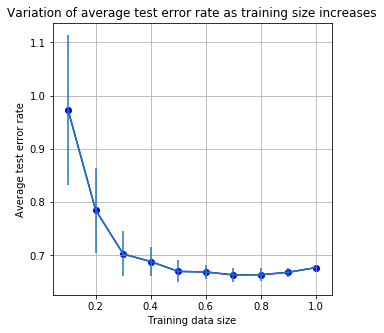

In [295]:
plot_graph(np.arange(.1,1.1,.1),mean_size,std_size)

• Average error rate is decreasing as the training size os increasing.<br>
• Standard deviation also reduces with increase in training size.<br>
• Average number of iterations required to converge to optimal solution is 10.<br>
• Average run time increases as the training sample size increases.<br>

<b> Are the learning curves as expected? </b><br>
Yes, the learning curves are as expected. The error rate decreases as the training sample size increases and the satandard deviation reduces.<br>

<b>Q)How does Learning time vary across datasets?</b><br>
Learning time increases as we increase the training set and it is different for different datsets.<br>

<b>Q) How does learning time vary across Likelihood models?</b><br>
Learning time is in this order poisson<logistic<ordinal for different likelihood models.

<b>Q) What are the main costs affecting these?</b><br>
Time per iteration is mainly affected by how long it takes to update W. This depends on calculating Hessian_inverse and gradient which in turn depends oon the training sample size.<br>
Number of iterations depend on how our likelihood function looks like and what is starting point we are choosing( that is initial W).

# Extra Credit

#### Using Evidence maximisation for hyperparameter optimisation
( The calculations for calculating evidence function are shown in calculation.pdf)

In [56]:
def train_GLM2(X_train,t_train,model,ob,alpha):
    W_new=np.zeros(shape=(np.shape(X_train)[1],1))
    W_old=np.ones(shape=(np.shape(X_train)[1],1))
    itr=0
    while(not check_convergence(W_new,W_old,itr)):
        Y=calculate_y(W_new,X_train,t_train,model,ob)
        d=calculate_d(t_train,Y,model)
        R=calculate_r(Y,model,ob)
        gradient=calculate_gradient(X_train,d,W_new,alpha)
        hessian=calculate_hessian(X_train,R,alpha)
        W_old=W_new
        W_new=update_W(W_old,hessian,gradient)
        itr+=1
    #print(itr)   
    return W_new,R

def experiment_with_optimisation(X_train,t_train,model,alpha_old,alpha_new,ob=None):
    
    while(abs(alpha_new-alpha_old)>1e-4):
        W_MAP,R=train_GLM2(X_train,t_train,model,ob,alpha_new)
        Gamma=calculate_Gamma(alpha_old,X_train,R)
        alpha_old=alpha_new
        alpha_new=calculate_alpha_new(Gamma,W_MAP)
    return W_MAP,alpha_new

##### Dataset (A)

In [306]:
alpha_old=0
alpha_new=np.random.uniform(1,10,1)[0] # Initialising hyperparameter.
model='Logistic'
data_path='pp3data\\A.csv'
label_path='pp3data\labels-A.csv'

data=get_data(data_path)
ones=np.ones(shape=(np.shape(data)[0],1))
data=np.hstack((ones,data))

label=get_data(label_path)
label=label.reshape(len(label),1)
    
X_train,t_train,\
X_test,t_test=split_data(data,label)
    
W_MAP,alpha=experiment_with_optimisation(X_train,t_train,model,alpha_old,alpha_new)

In [307]:
t_predict=predict_label(X_test,W_MAP,model)
error=calculate_error(t_predict,t_test,model)
print("Optimal alpha is : "+str(alpha)+" and error corresponding to this alpha is : "+str(error))

Optimal alpha is : 0.004507773399604427 and error corresponding to this alpha is : 0.03903903903903904


This error is significantly lower than what we got when we used arbitrary alpha(=10) above. It also converged very fast. Had we used cross validation for hyperparameter tuning, it would have taken much longer to find optimal alpha.

#### Dataset (usps)

In [59]:
alpha_old=0
alpha_new=np.random.uniform(1,10,1)[0] # Initialising hyperparameter.
model='Logistic'
data_path='pp3data\\usps.csv'
label_path='pp3data\\labels-usps.csv'

data=get_data(data_path)
ones=np.ones(shape=(np.shape(data)[0],1))
data=np.hstack((ones,data))

label=get_data(label_path)
label=label.reshape(len(label),1)
    
X_train,t_train,\
X_test,t_test=split_data(data,label)
    
W_MAP,alpha=experiment_with_optimisation(X_train,t_train,model,alpha_old,alpha_new)

In [60]:
t_predict=predict_label(X_test,W_MAP,model)
error=calculate_error(t_predict,t_test,model)
print("Optimal alpha is : "+str(alpha)+" and error corresponding to this alpha is : "+str(error))

Optimal alpha is : 6.793451020597337 and error corresponding to this alpha is : 0.025341130604288498


This error is significantly lower than what we got when we used arbitrary alpha(=10) above. It also converged very fast. Had we used cross validation for hyperparameter tuning, it would have taken much longer to find optimal alpha.

#### Dataset(AP)

In [71]:
alpha_old=0
alpha_new=np.random.uniform(1,10,1)[0] # Initialising hyperparameter.
model='Poisson'
data_path='pp3data\\AP.csv'
label_path='pp3data\\labels-AP.csv'

data=get_data(data_path)
ones=np.ones(shape=(np.shape(data)[0],1))
data=np.hstack((ones,data))

label=get_data(label_path)
label=label.reshape(len(label),1)
    
X_train,t_train,\
X_test,t_test=split_data(data,label)
    
W_MAP,alpha=experiment_with_optimisation(X_train,t_train,model,alpha_old,alpha_new)

In [72]:
t_predict=predict_label(X_test,W_MAP,model)
error=calculate_error(t_predict,t_test,model)
print("Optimal alpha is : "+str(alpha)+" and error corresponding to this alpha is : "+str(error))

Optimal alpha is : 10.4699318508741 and error corresponding to this alpha is : 0.9624987936324793


This error is again close to what we got when we used arbitrary alpha(=10) above. Because here optimal alpha is very close to 10. It also converged very fast. Had we used cross validation for hyperparameter tuning, it would have taken much longer to find optimal alpha.

#### Dataset(AO)
( I havent optimised for s and phi(j) but have shown the calculations in calculations.pdf)

In [308]:
alpha_old=0
alpha_new=np.random.uniform(1,10,1)[0] # Initialising hyperparameter.
model='Ordinal'
data_path='pp3data\\AO.csv'
label_path='pp3data\\labels-AO.csv'

ob=Ordinal(s,phi)

data=get_data(data_path)
ones=np.ones(shape=(np.shape(data)[0],1))
data=np.hstack((ones,data))

label=get_data(label_path)
label=label.reshape(len(label),1)
    
X_train,t_train,\
X_test,t_test=split_data(data,label)
    
W_MAP,alpha=experiment_with_optimisation(X_train,t_train,model,alpha_old,alpha_new,ob)

In [309]:
t_predict=predict_label(X_test,W_MAP,model,ob)
error=calculate_error(t_predict,t_test,model)
print("Optimal alpha is : "+str(alpha)+" and error corresponding to this alpha is : "+str(error))

Optimal alpha is : 1.6699560137021872 and error corresponding to this alpha is : 0.6831831831831832


This error is significantly lower than what we got when we used arbitrary alpha(=10) above. It also converged very fast. Had we used cross validation for hyperparameter tuning, it would have taken much longer to find optimal alpha.